In [1]:
import time
import logging
from binance.lib.utils import config_logging
from binance.websocket.um_futures.websocket_client import UMFuturesWebsocketClient
from binance.um_futures import UMFutures
from binance.error import ClientError

import matplotlib.pyplot as plt
import seaborn as sns

from cert import binanceKey
from cert import test_binanceKey
from cert.myfuncs import *


# import API KEY and SECRET KEY
## realnet (base_url is realnet default)
API_KEY = binanceKey.API_KEY
SECRET_KEY = binanceKey.SECRET_KEY
## testnet
key = test_binanceKey.API_KEY
secret = test_binanceKey.SECRET_KEY
## testnet base_urls (for test trading, stream_url = futures_websocket_testnet and base_url = futures_testnet)
futures_testnet = test_binanceKey.futures_testnet
futures_websocket_testnet = test_binanceKey.futures_websocket_testnet
# END


# defining futures client
um_futures_client = UMFutures(key=key, secret=secret, base_url=futures_testnet) # testnet
my_client = UMFuturesWebsocketClient(stream_url=futures_websocket_testnet) # testnet
# END

# 1. Conduct Prelim
1. klines graph & MA, MACD
2. volatility

In [2]:
# 1. class
from trade_rules.trade_prelim import DataPrelim

predata = DataPrelim(um_futures_client)
pre_kline = predata.prelim_kline("2h", limit=1500)
pre_vol = predata.prelim_volatility(window=30)

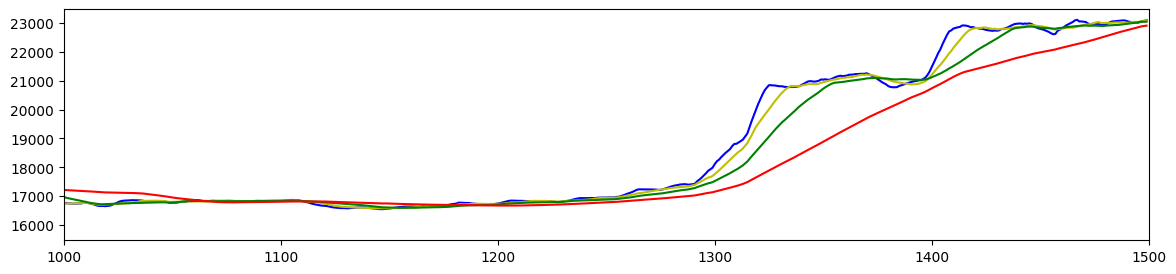

In [3]:
# 2. ma
plt.figure(figsize=(14, 3))
plt.plot(np.arange(1500), pre_kline['Close'].rolling(10).mean(), c='b')
plt.plot(np.arange(1500), pre_kline['Close'].rolling(20).mean(), c='y')
plt.plot(np.arange(1500), pre_kline['Close'].rolling(40).mean(), c='g')
plt.plot(np.arange(1500), pre_kline['Close'].rolling(100).mean(), c='r')
plt.xlim(1000, 1500)
plt.show()

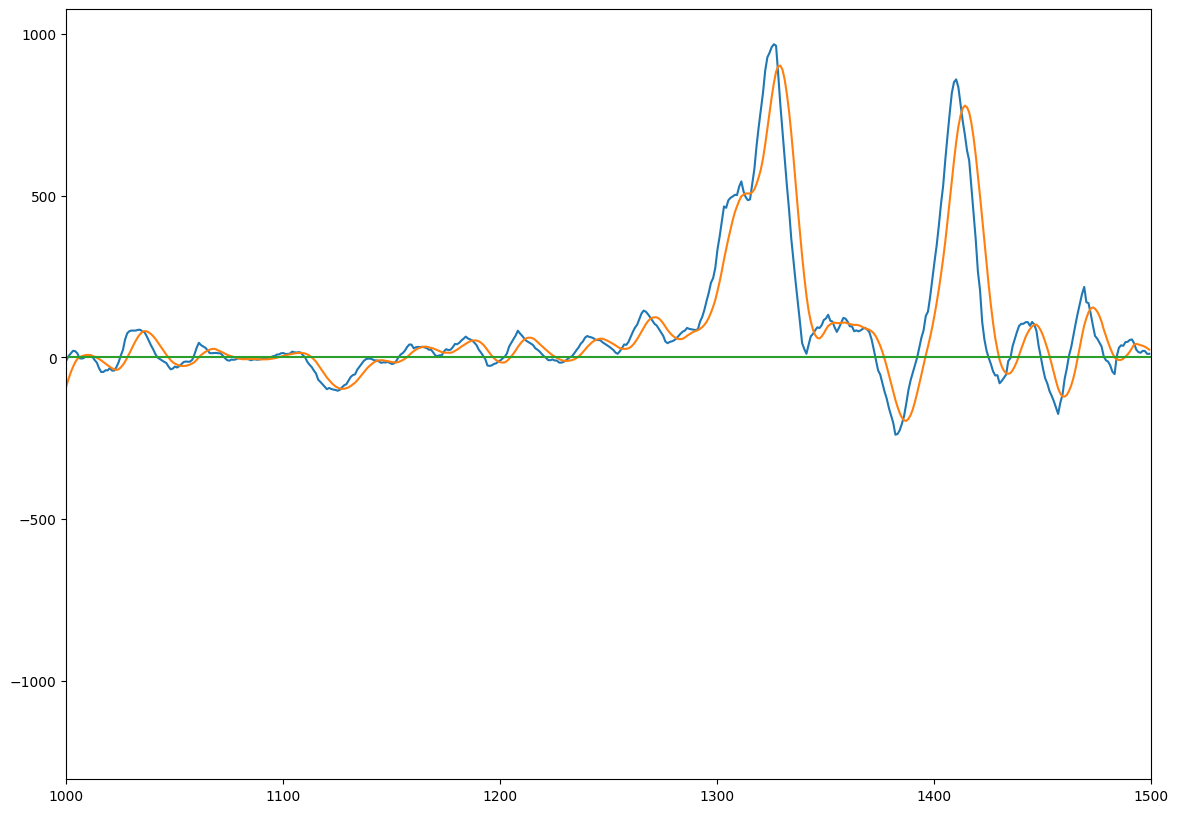

In [4]:
# 3. macd
pre_macd = pre_kline['Close'].rolling(12).mean() - pre_kline['Close'].rolling(26).mean()
pre_macd_sig = pre_macd.rolling(9).mean()
plt.figure(figsize=(14, 10))
plt.plot(pre_macd)
plt.plot(pre_macd_sig)
plt.plot([0, 1500], [0, 0])
plt.xlim(1000, 1500)
plt.show()

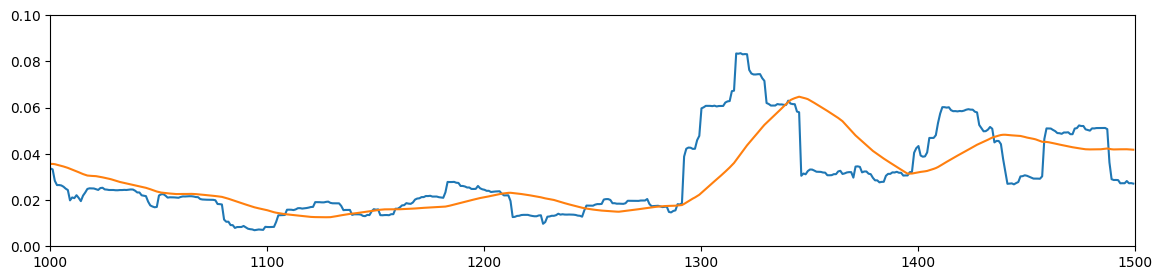

In [5]:
# 4. volatility
plt.figure(figsize=(14, 3))
plt.plot(pre_vol)
plt.plot(np.arange(1500), pre_vol.rolling(50).mean())
plt.xlim(1000, 1500)
plt.ylim(0, 0.1)
plt.show()

# 2. Collect RealTime Data
- websocket client를 열고, user data 및 kline, aggTrade, markPrice, book_ticker 등 가져온다.
  - aggTrade와 markPrice만 받을 수 있음, 23.01.29에 업데이트
- 추가되는 df를 계속 관찰하며 condition을 체크하는 함수를 만들 예정
- condition에 따라 buy/sell하는 함수를 만들 예정
- 이 모든 절차를 하나의 함수에 몰아넣어야 함. --> callback 함수에 parameter로 넣어야 한다
- 거래까진 해보자

In [6]:
# # defining futures client
# um_futures_client = UMFutures(key=key, secret=secret, base_url=futures_testnet) # testnet
# my_client = UMFuturesWebsocketClient(stream_url=futures_websocket_testnet) # testnet
# # END

In [7]:
listenKey = predata.new_listenKey()
asset_USDT, position_BTCUSDT = predata.get_account()

current_asset = asset_USDT['walletBalance']
positionAmt, entryPrice = position_BTCUSDT['positionAmt'], position_BTCUSDT['entryPrice']

In [8]:
# defining websocket streams
## parameters.
SYMBOL = "btcusdt"
p_aggTrade = dict()
p_markPrice = dict(
    speed=1,
)
p_kline = dict(
    interval='2h'
)
## make each streams
aggTrade_stream = f"{SYMBOL}@aggTrade"
markPrice_stream = f"{SYMBOL}@markPrice@{p_markPrice['speed']}s"
kline_stream = f"{SYMBOL}@kline_{p_kline['interval']}"
listenKey = listenKey

## make stream lists
stream = [
    aggTrade_stream,
    markPrice_stream,
    kline_stream,
    listenKey,
]
# END

In [9]:
# defining stream data collector
from trade_rules.trader import Trader
trader = Trader(current_asset, listenKey, aggTrade=aggTrade_stream, markPrice=markPrice_stream, kline=kline_stream)
# END

# websocket start
config_logging(logging, logging.DEBUG)

my_client.start()

my_client.live_subscribe(
    stream=stream,
    id=1,
    callback=trader.my_callback,
)

time.sleep(1000)

logging.debug("closing ws connection")
my_client.stop()

In [11]:
markPriceDf = trader.df_store['markPriceUpdate']

In [15]:
markPrice = markPriceDf.p.astype(float)

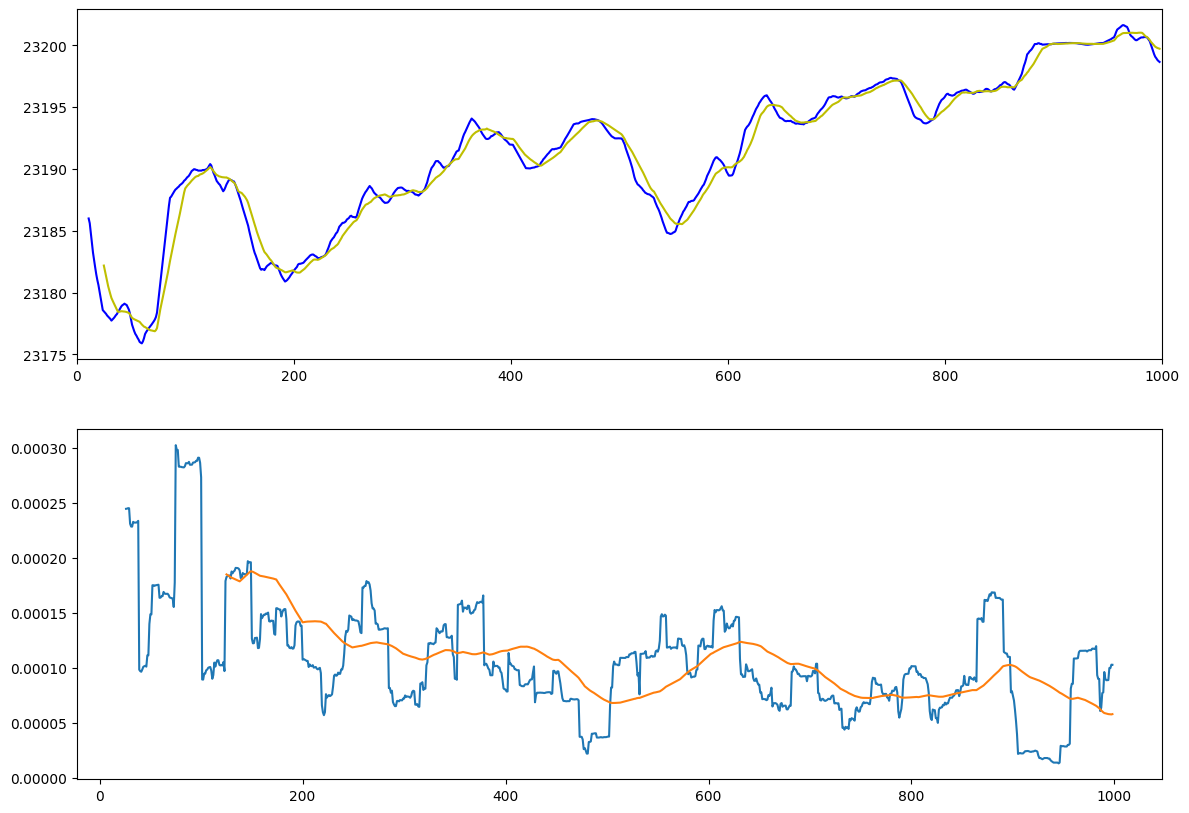

In [39]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
# plt.plot(np.arange(999), markPrice, c='r')
plt.plot(np.arange(999), markPrice.rolling(12).mean(), c='b')
plt.plot(np.arange(999), markPrice.rolling(26).mean(), c='y')
plt.xlim(0, 1000)

plt.subplot(2, 1, 2)
plt.plot(log_return(markPrice).rolling(26).apply(realized_volatility))
plt.plot(log_return(markPrice).rolling(26).apply(realized_volatility).rolling(100).mean())

plt.show()